In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

2025-12-03 03:55:29.985150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764734130.221074      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764734130.284032      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [4]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 10

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  # 15% for validation, 15% for test
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05
)

In [6]:
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)


Found 73950 images belonging to 29 classes.


In [8]:
validation_generator = val_test_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 13050 images belonging to 29 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
test_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=123  # Different seed to get different samples
)


Found 87000 images belonging to 29 classes.


In [11]:
total_samples = train_generator.samples + validation_generator.samples
test_steps = int(total_samples * 0.15 / BATCH_SIZE)

In [12]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples (approx): {test_steps * BATCH_SIZE}")

Number of classes: 29
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Training samples: 73950
Validation samples: 13050
Test samples (approx): 12992


In [13]:
model = keras.Sequential([
    # First Convolutional Block
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Second Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Third Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764734188.797468      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764734188.798190      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,365 (1.23 MB)

 Trainable params: 322,365 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

In [17]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)


In [18]:
print("\nTraining the model...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1764734193.236612     125 service.cc:148] XLA service 0x7a2820048ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764734193.237735     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764734193.237754     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764734193.674906     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1156 ━━━━━━━━━━━━━━━━━━━━ 2:25:04 8s/step - accuracy: 0.0156 - loss: 3.4644

I0000 00:00:1764734198.588045     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 467s 397ms/step - accuracy: 0.0612 - loss: 3.2931 - val_accuracy: 0.2330 - val_loss: 2.5780 - learning_rate: 3.0000e-04
Epoch 2/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 216s 187ms/step - accuracy: 0.3066 - loss: 2.2972 - val_accuracy: 0.4353 - val_loss: 1.8444 - learning_rate: 3.0000e-04
Epoch 3/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 224s 194ms/step - accuracy: 0.4468 - loss: 1.7243 - val_accuracy: 0.5196 - val_loss: 1.5402 - learning_rate: 3.0000e-04
Epoch 4/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 221s 191ms/step - accuracy: 0.5330 - loss: 1.4261 - val_accuracy: 0.5860 - val_loss: 1.3376 - learning_rate: 3.0000e-04
Epoch 5/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 222s 192ms/step - accuracy: 0.5908 - loss: 1.2288 - val_accuracy: 0.6162 - val_loss: 1.2223 - learning_rate: 3.0000e-04
Epoch 6/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 220s 191ms/step - accuracy: 0.6334 - loss: 1.0919 - val_accuracy: 0.6693 - val_loss: 1.1125 - learning_rate: 3.0000e-04
Epoch 7/10
1156/1156 ━━━━━━━━━━━━━━━━━━

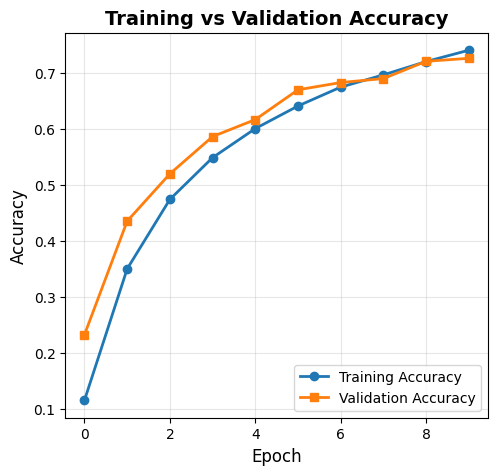

In [19]:
# 1. Training and Validation Accuracy Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

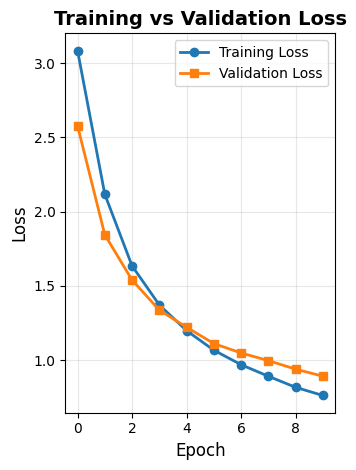

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
print("\nEvaluating model on test data...")


Evaluating model on test data...


In [22]:
# Get predictions on test data
test_generator.reset()
y_pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step


In [23]:
# Get corresponding true labels
y_true = []
test_generator.reset()
for i in range(test_steps):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
y_true = np.array(y_true)

In [24]:
# Ensure same length
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

In [28]:
class_labels = list(train_generator.class_indices.keys())

In [29]:
# Get unique classes present in test set
unique_classes_in_test = np.unique(np.concatenate([y_true, y_pred]))
test_class_labels = [class_labels[i] for i in unique_classes_in_test]

In [35]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")


Final Training Accuracy:   0.7399 (73.99%)
Final Validation Accuracy: 0.7254 (72.54%)
